In [1]:
## Image Processing Functions

In [2]:
## SOURCES

# Basic Camera Manipulations : https://dev.to/azure/opencv-access-to-a-camera-in-a-jupyter-notebook-with-python-18mb
# Vertice Detection : https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html
# Distinguish one obstacle from the other : https://scipy-lectures.org/advanced/image_processing/auto_examples/plot_synthetic_data.html#sphx-glr-advanced-image-processing-auto-examples-plot-synthetic-data-py
# Color Detection : https://notebook.community/ricklon/opencvraspberrypi/notebook/openCV%20color%20detection
# Color Detectin : https://discover.hubpages.com/technology/Color-spaces-RGB-vs-HSV-Which-one-to-use

# https://datacarpentry.org/image-processing/aio/index.html

# Center of contour : https://pyimagesearch.com/2016/02/01/opencv-center-of-contour/

# M : https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
    
    

In [2]:
# Import Libraries

import cv2
import cv2 as cv
from matplotlib import pyplot as plt
import math
from math import atan2, cos, sin, sqrt, pi
import numpy as np

In [3]:
img = cv2.imread('/Users/noah/Desktop/python/MobileRobotics/imageproc/sample2_image.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_blur = cv2.bilateralFilter(img_rgb,9,75,75)
plt.imshow(img_blur);

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [4]:
def get_goal_position(filtered_img):
    
    # RETURNS TUPLE (X,Y) CORRESPONDING TO COORDINATES OF CENTER OF END GOAL POSITION
    
    filtered_img_hsv = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2HSV) # convert rgb to hsv
    min_blue = np.array([60, 0, 0])
    max_blue = np.array([150, 255, 255])
    mask = cv2.inRange(filtered_img_hsv, min_blue, max_blue) # mask for blue color
    
    output = cv2.bitwise_and(filtered_img, filtered_img, mask=mask)
    
    ret,thresh = cv2.threshold(mask, 40, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # use for geometrical shapes : CHAIN_APPROX_SIMPLE 
    
    if len(contours) != 0:

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        M = cv.moments(c)
        x_center = int(M['m10']/M['m00'])
        y_center = int(M['m01']/M['m00'])
        
    (x,y),radius = cv.minEnclosingCircle(c)
    center = (int(x),int(y))
    radius = int(radius)
    cv.circle(output,center,radius,(0,255,0),10) 
    plt.imshow(output)
          
        
    return (x_center,y_center)

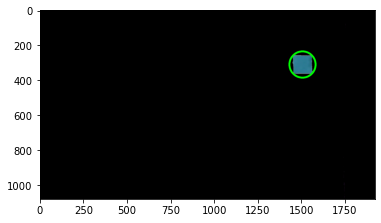

In [5]:
x_center,y_center = get_goal_position(img_blur)

In [6]:
# https://stackoverflow.com/questions/66655408/draw-a-line-on-an-image-using-angle-and-center-point-using-python
# Used to draw thymios orientation
import math

def get_coords(x, y, angle, imwidth, imheight):

    x1_length = (x-imwidth) / math.cos(angle)
    y1_length = (y-imheight) / math.sin(angle)
    length = max(abs(x1_length), abs(y1_length))
    endx1 = x + length * math.cos(math.radians(angle))
    endy1 = y + length * math.sin(math.radians(angle))

    x2_length = (x-imwidth) / math.cos(angle+180)
    y2_length = (y-imheight) / math.sin(angle+180)
    length = max(abs(x2_length), abs(y2_length))
    endx2 = x + length * math.cos(math.radians(angle+180))
    endy2 = y + length * math.sin(math.radians(angle+180))

    return endx1, endy1, endx2, endy2

In [7]:
def get_thymio_position(filtered_img):
    
    # RETURNS CENTER COORDINATES, RADIUS AND ORIENTATION (provides extra coordinants (xb, yb) to know which direction, as well as angle) OF THYMIO ROBOT
    
    filtered_img_hsv = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2HSV) # convert rgb to hsv
    min_red = np.array([0, 125, 200]) # before [0, 0, 220]
    max_red = np.array([80, 255, 255]) # before [30, 255, 255]
    mask = cv2.inRange(filtered_img_hsv, min_red, max_red) # mask for red color
    
    output = cv2.bitwise_and(filtered_img, filtered_img, mask=mask)
    
    ret,thresh = cv2.threshold(mask, 40, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    if len(contours) != 0:

        # find the biggest countour (c) by the area
        c = max(contours, key = cv2.contourArea)
        M = cv.moments(c)
        x_M = int(M['m10']/M['m00'])
        y_M = int(M['m01']/M['m00'])
        
        (x_circle,y_circle),radius = cv.minEnclosingCircle(c)
        center_circle = (int(x_circle),int(y_circle))
        radius = int(radius)
        cv.circle(output,center_circle,radius,(0,255,0),10) 
    
    
        # cv.minAreaRect returns: (center(x, y), (width, height), angle of rotation) 
        rect = cv.minAreaRect(c)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        center_rect = (int(rect[0][0]),int(rect[0][1])) 
        width = int(rect[1][0])
        height = int(rect[1][1])
        angle = int(rect[2])

        cv.drawContours(output,[box],0,(255,0,0),10)
        
        
        #pca_center, pca_p1, pca_p2, pca_angle = getOrientation(c,output) # not very accurate for now
        angle2 = math.degrees(atan2((center_circle[1]-center_rect[1]),(center_circle[0]-center_rect[0])))
        
        endx1, endy1, endx2, endy2 = get_coords(center_circle[0], center_circle[1], angle2, filtered_img.shape[1], filtered_img.shape[0])
        
        cv.line(output,(int(endx1),int(endy1)),(int(endx2),int(endy2)),(200,0,225),15)
        plt.imshow(output)
        
    return (center_circle, radius, center_rect, angle2)

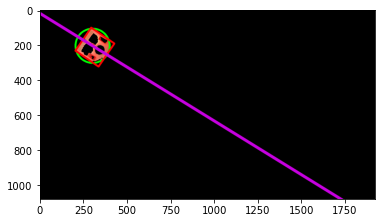

In [8]:
center_circle, radius, center_rect, angle2 = get_thymio_position(img_blur)

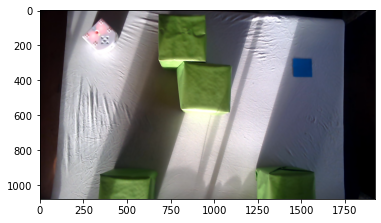

In [9]:
# New sample image:
img = cv2.imread('/Users/noah/Desktop/python/MobileRobotics/imageproc/sample3_image.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_blur = cv2.bilateralFilter(img_rgb,9,75,75)
plt.imshow(img_blur);

In [10]:
import cv2
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt


def f (hMin ,hMax ,Smin,Smax ,Vmin,Vmax):
    #img1 = img
    #img = cv2.cvtColor(img1 ,cv2.COLOR_BGR2RGB)  #in matplot image show in rgb format in cv2 it show in bgr format remeber this else you will face problem
    hsv = cv2.cvtColor(img_rgb,cv2.COLOR_RGB2HSV)# if you are going to use cv2 to show image then cv2.COLOR_BGR2HSV 
    Lhsv = np.array([hMin,Smin,Vmin])
    Uhsv = np.array([hMax ,Smax,Vmax])
    mask = cv2.inRange(hsv,Lhsv ,Uhsv)
    r = cv2.bitwise_and(img_rgb,img_rgb,mask =mask)
    
    
    plt.imshow(r)
  
    
interactive_plot = interactive(f,hMin=(0,179),hMax = (0,179),Smin = (0,250),Smax =(0,255),Vmin=(0,255),Vmax=(0,255))

In [11]:
interactive_plot

interactive(children=(IntSlider(value=89, description='hMin', max=179), IntSlider(value=89, description='hMax'…

In [12]:
def get_obstacle_position(filtered_img, thymio_radius, min_green = np.array([30, 87, 0]), max_green = np.array([90, 255, 255])):
    
    # RETURNS LIST OF VERTICES AND NUMBER OF OBSTACLES
    
    filtered_img_hsv = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2HSV) # convert rgb to hsv
    mask = cv2.inRange(filtered_img_hsv, min_green, max_green) # mask for green color
    mask = cv2.medianBlur(mask,15) # Remove noise in the mask
    ret,thresh = cv2.threshold(mask, 40, 255, 0) # Could remove this
    
    output = cv2.bitwise_and(filtered_img, filtered_img, mask=mask)
    
    
    dilatation_size = int(thymio_radius)
    kernel = cv2.getStructuringElement(cv.MORPH_RECT, (2 * dilatation_size + 1,2 * dilatation_size + 1))
    thresh_dilated = cv2.dilate(thresh, kernel, iterations = 1)
    
    contours, hierarchy = cv2.findContours(thresh_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # use for geometrical shapes : CHAIN_APPROX_SIMPLE 
    
    if len(contours) != 0:
        
        nb_obstacles = 0
        vertices = []
        

        for c in contours:
            area = cv.contourArea(c)

            if area > 1000:
                nb_obstacles += 1

                epsilon = 0.015*cv.arcLength(c,True)
                approx = cv.approxPolyDP(c,epsilon,True)
                cv2.drawContours(output, [approx], -1, (0, 255, 255), 20)
                print(approx)
                vertices.append(approx)                 
                
                
                # Plotting for troubleshooting

                plt.figure(figsize=(9,3))

                plt.subplot(131)
                plt.imshow(mask, cmap=plt.cm.gray)
                plt.axis('off')
                plt.subplot(132)
                plt.imshow(thresh_dilated)
                plt.axis('off')
                plt.subplot(133)
                plt.imshow(output)
                plt.axis('off')

                plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=1)
                plt.show()
     
 
    plt.imshow(output)
          
        
    return (vertices, nb_obstacles)

[[[ 248  848]]

 [[ 238 1079]]

 [[ 765 1075]]

 [[ 756  814]]

 [[ 377  805]]]


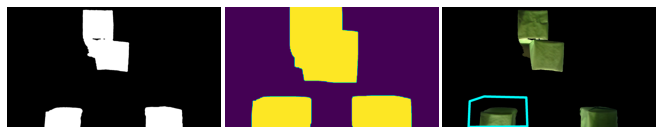

[[[1144  810]]

 [[1146 1079]]

 [[1674 1079]]

 [[1661  826]]

 [[1517  796]]]


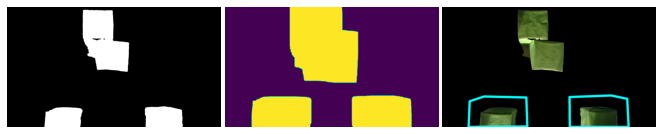

[[[ 581    0]]

 [[ 583  377]]

 [[ 710  659]]

 [[1176  680]]

 [[1193  228]]

 [[1053  205]]

 [[1049    0]]]


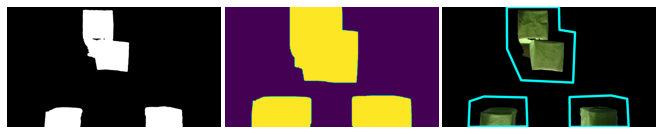

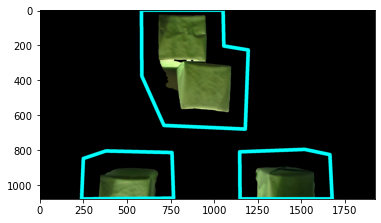

In [13]:
vertices, nb_obstacles = get_obstacle_position(img_blur,98)